In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from trainer.supervised_trainer import SupervisedTrainer
from trainer.supervised_trainer_unmatching import SupervisedTrainer_unmatching
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import numpy as np

from sklearn.manifold import TSNE

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
train_path = "../../data/bracket_dedup/K100/data_train.txt"
log_path = "../../log/pth/bracket_dedup_K100_parameter_Luong_att_model_save.pth"
log_path_no = "../../log/pth/bracket_dedup_K100_parameter_no_att_model_save.pth"

In [3]:
LOG_FORMAT = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, "info".upper()))

In [4]:
# Prepare dataset
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)

In [5]:
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

In [6]:
# Prepare loss
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

seq2seq = None
seq2seq_no = None
optimizer = "Adam"
hidden_size = 50
bidirectional = True

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Initialize model Luong att

In [7]:
# Initialize model
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=1,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional, n_layers=1,
                    eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

seq2seq.load_state_dict(torch.load(log_path))
seq2seq.eval()

predictor = Predictor(seq2seq, input_vocab, output_vocab)

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Initialize model no att

In [8]:
# Initialize model no att
encoder_no = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=1,
                    bidirectional=bidirectional, variable_lengths=True)
decoder_no = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention=None, bidirectional=bidirectional, n_layers=1,
                    eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq_no = Seq2seq(encoder_no, decoder_no)
if torch.cuda.is_available():
    seq2seq_no.cuda()

for param in seq2seq_no.parameters():
    param.data.uniform_(-0.08, 0.08)

seq2seq_no.load_state_dict(torch.load(log_path_no))
seq2seq_no.eval()


predictor_no = Predictor(seq2seq_no, input_vocab, output_vocab)

# Answer function

In [9]:
def answer_function(data):
    result = []
    num = 0
    for i in data:
        if i == "{" or i == "[":
            num += 1
            result.append(str(num))
        else:
            num -= 1
            result.append(str(num))

    return " ".join(result)

# Step function

In [10]:
def step_function(x):
    
    if x > 0:
        if x < 0.5:
            return 0
        else:
            return 1
    else:
        if x > -0.5:
            return 0
        else:
            return -1

# Predict

input : [ { { } } ] [ [ [ [ ] ] ] [ { } ] ]


/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Answer: 1 2 3 2 1 0 1 2 3 4 3 2 1 2 3 2 1 0
Luong : 1 2 3 2 1 0 1 2 3 4 3 2 1 2 3 2 1 0 <eos>
None  : 1 2 3 2 1 0 1 2 3 4 3 2 1 2 3 2 1 0 <eos>
[[ 0.08633499 -0.11011562 -0.06216696 ...  0.00564732 -0.02295568
  -0.81659335]
 [ 0.29825485 -0.13971364 -0.07706909 ...  0.01402952 -0.03067757
  -0.7194677 ]
 [ 0.5701918  -0.06069352 -0.05222631 ...  0.16093971 -0.00291682
  -0.7553085 ]
 ...
 [-0.74804646  0.99842596  0.2929707  ... -0.9330082   0.00461153
   0.15963973]
 [-0.88279957  0.99847776  0.8374419  ... -0.7892414   0.00799694
   0.05476606]
 [-0.5565552   0.9984492   0.9712299  ... -0.15038233  0.62932545
   0.18512201]]


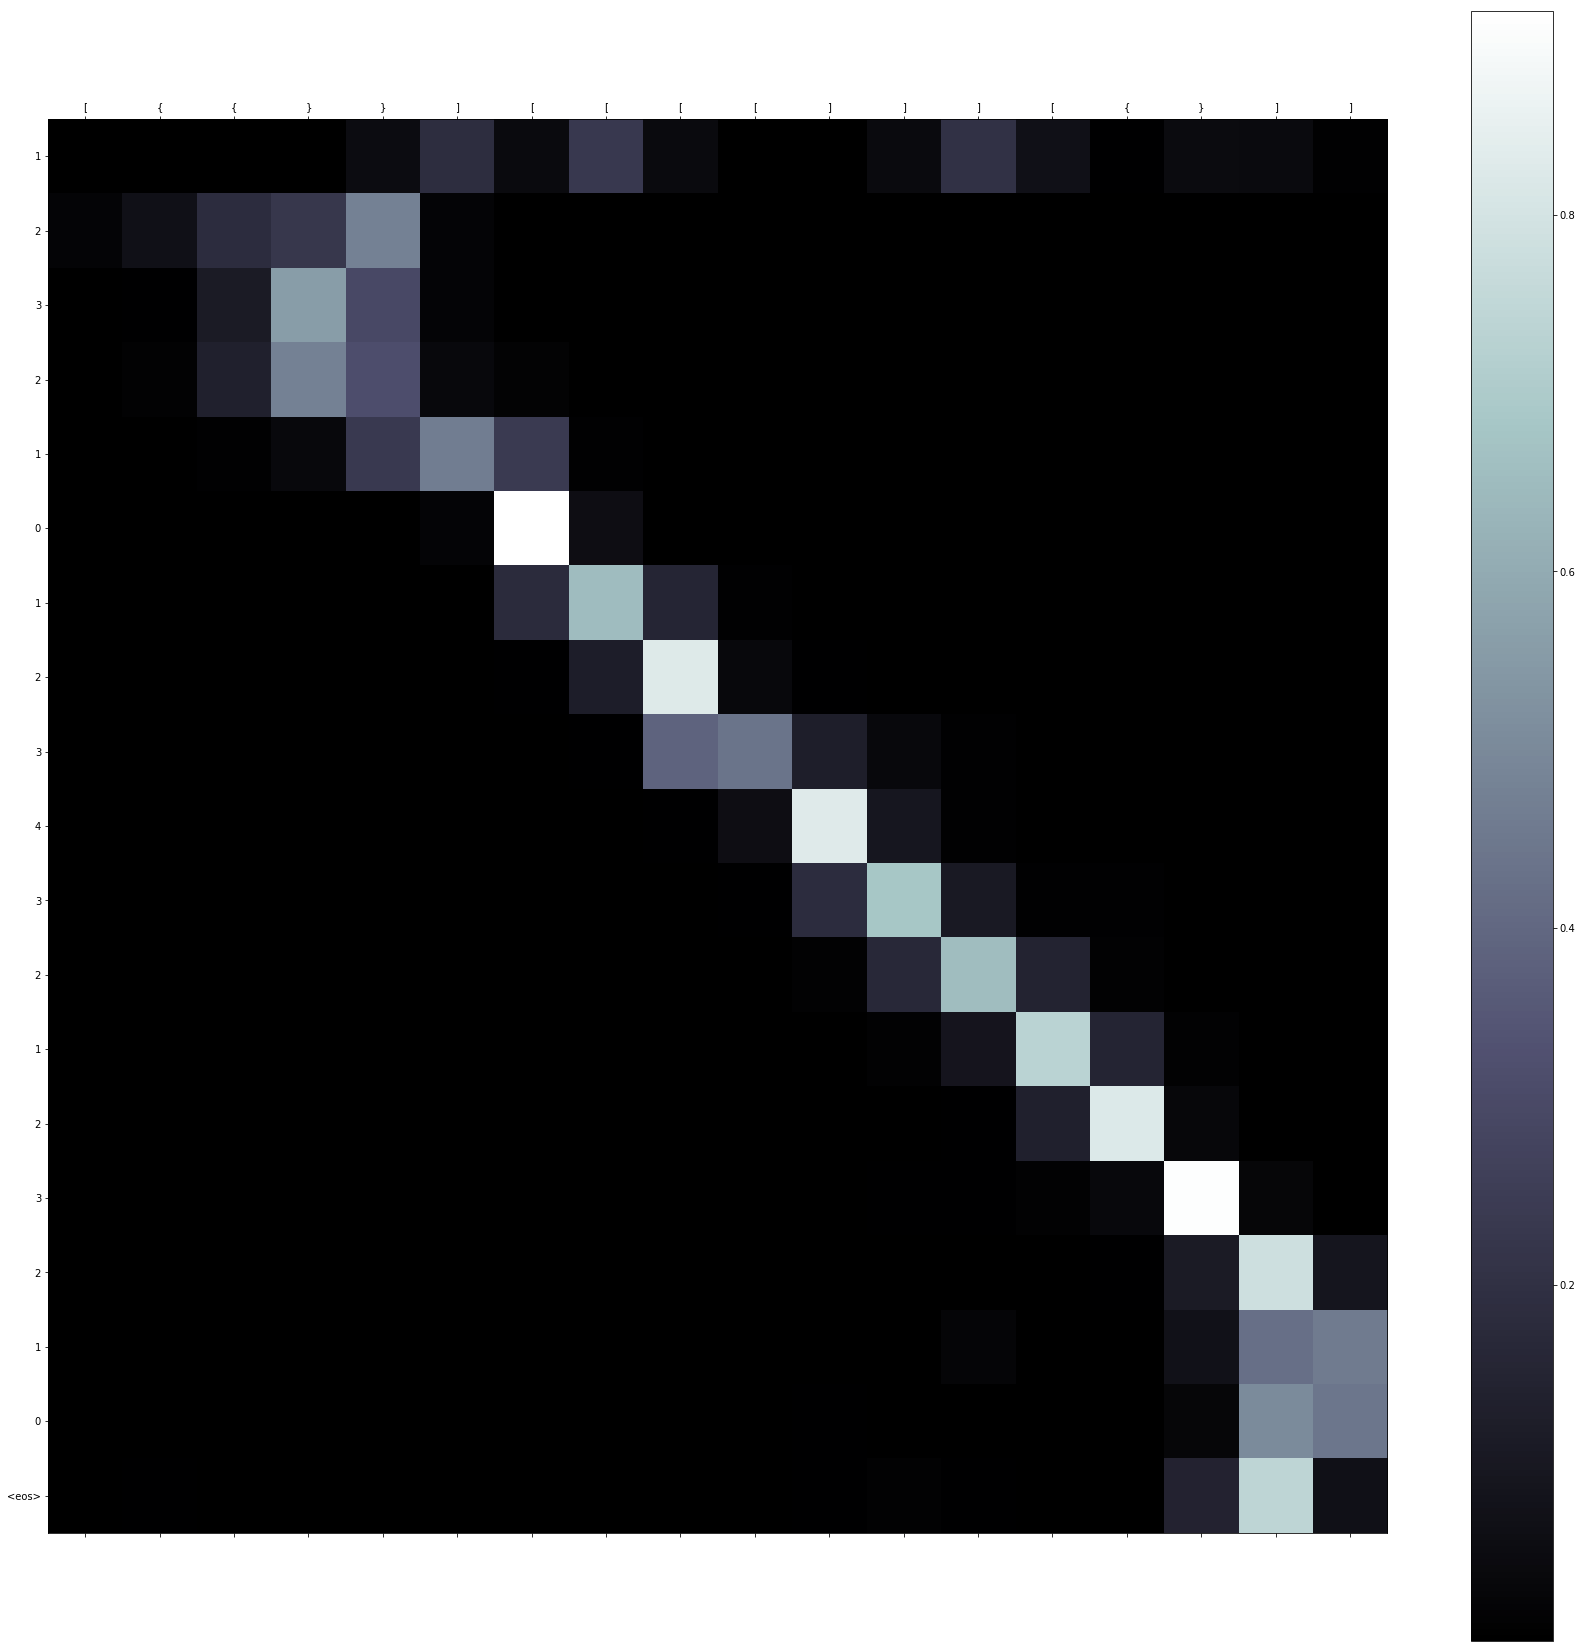

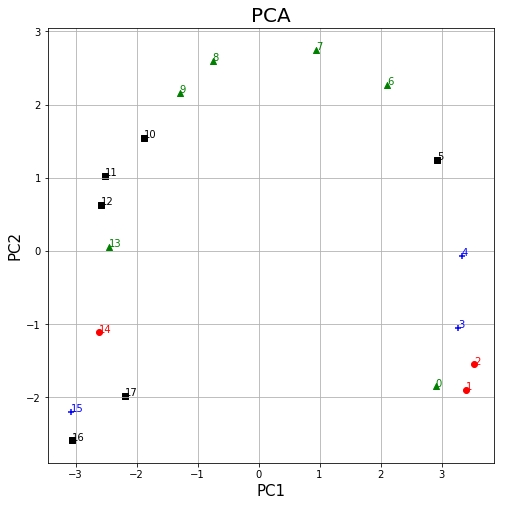

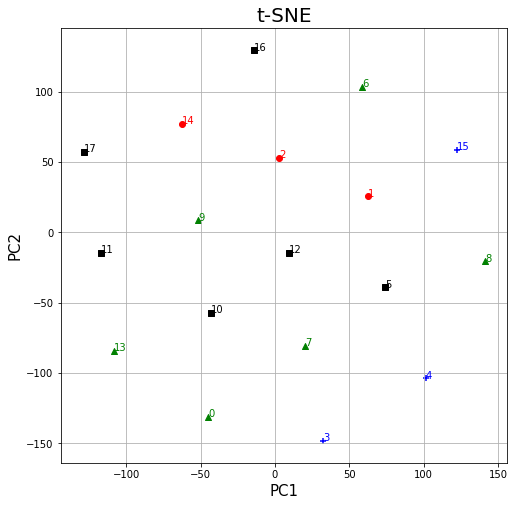

0 0 0 1 1 1 1 -1 -1 0 0 -1 -1 -1 0 0 -1 -1 -1
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1
0 0 0 0 0 -1 -1 0 1 1 1 1 0 -1 0 1 0 0 -1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1
0 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 -1 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
0 0 0 0 0 0 0 0 0 -1 -1 1 1 -1 -1 1 1 0 -1
0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 0
0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 0 0 -1 -1 0 0 -1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 0 0 0
0 0 -1 -1 -1 -1 -1 -1 1 1 1 0 1 1 1 0 0 1 1
0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0
0 0 0 1 1 1 1 1 1 1 1 1 1 1 

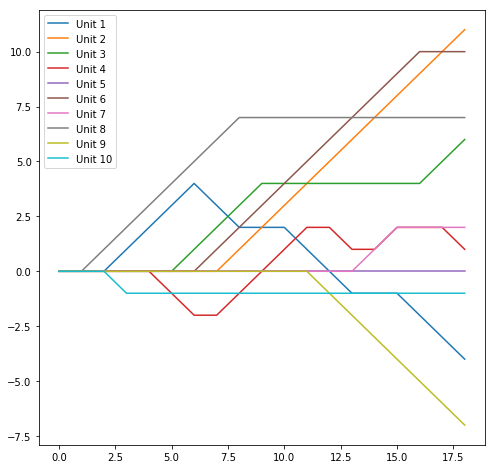

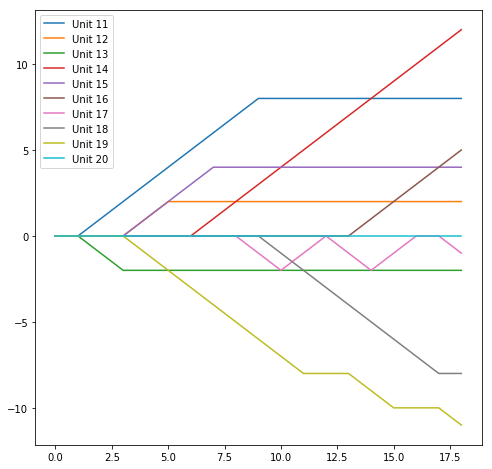

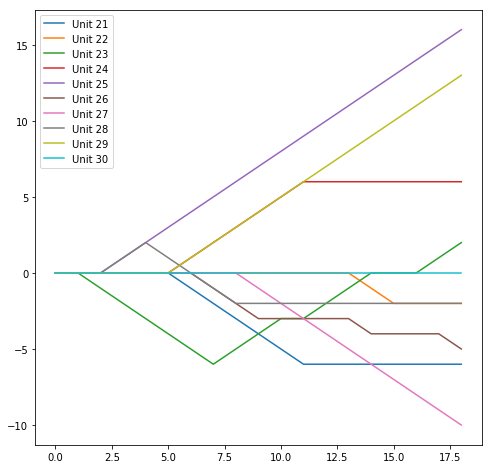

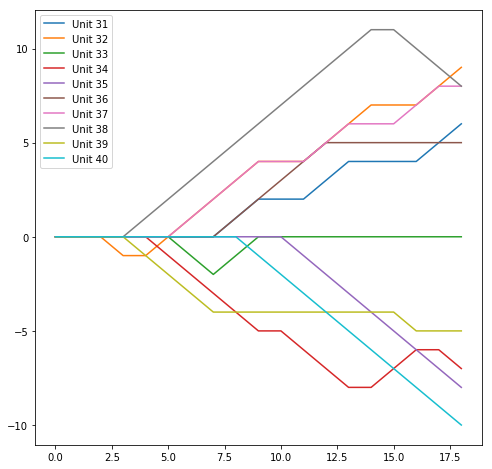

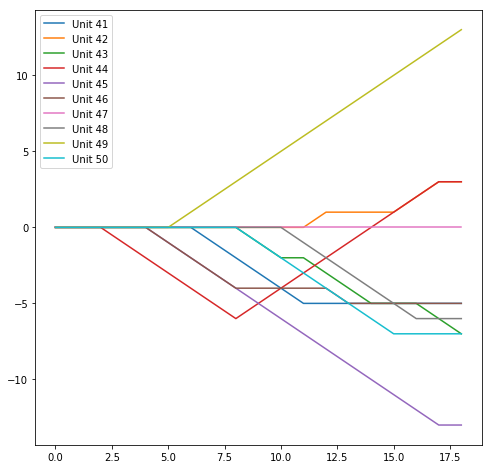

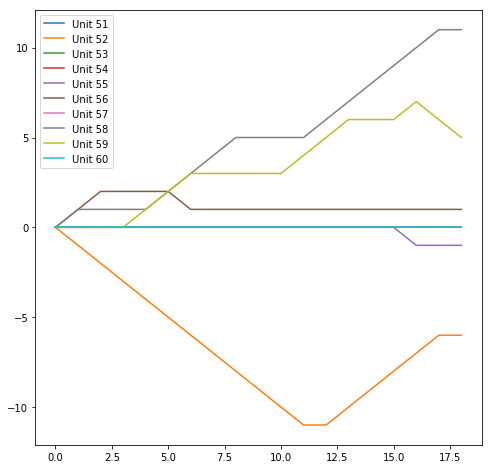

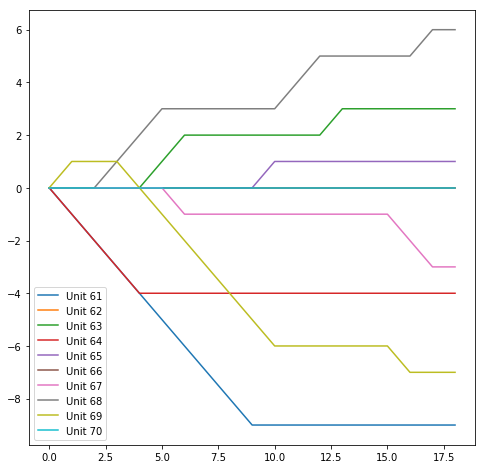

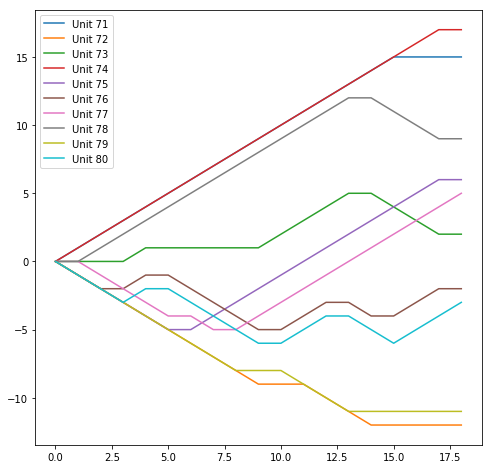

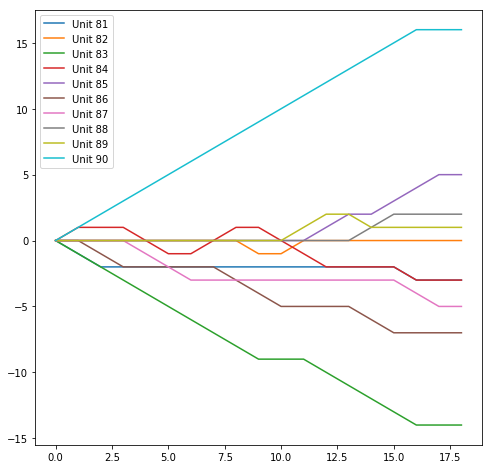

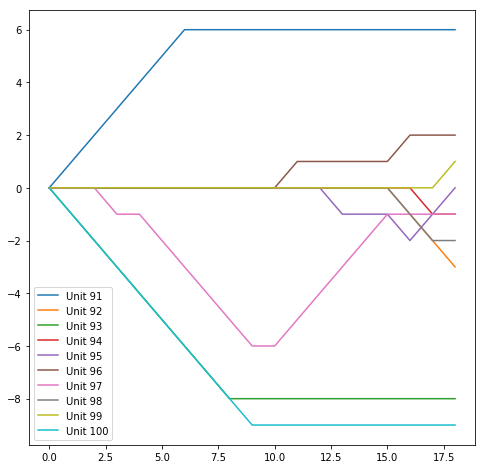

input : [ [ [ ] ] ] { { [ [ ] ] [ { { { } } } [ [ { { [ { [ [ ] ] { } } ] [ { } [ { [ [ ] ] } ] ] } } ] ] [ ] { [ ] [ [ ] [ [ [ ] { } ] ] { } ] } ] } [ { } ] } { [ [ ] ] }


/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Answer: 1 2 3 2 1 0 1 2 3 4 3 2 3 4 5 6 5 4 3 4 5 6 7 8 9 10 11 10 9 10 9 8 7 8 9 8 9 10 11 12 11 10 9 8 7 6 5 4 3 4 3 4 5 4 5 6 5 6 7 8 7 8 7 6 5 6 5 4 3 2 1 2 3 2 1 0 1 2 3 2 1 0
Luong : 1 2 3 2 1 0 1 2 3 4 3 2 3 4 5 6 5 4 3 4 5 6 7 8 9 10 11 10 9 10 9 8 7 8 9 8 9 10 11 12 11 10 9 8 7 6 5 4 3 4 3 4 5 4 5 6 5 6 7 8 7 8 7 6 5 6 5 4 3 2 1 2 3 2 1 0 1 2 3 2 1 0 <eos>
None  : 1 2 3 2 1 0 1 2 3 4 3 4 3 2 3 4 3 4 5 6 7 8 7 8 9 10 9 10 9 8 9 8 7 8 9 8 9 10 11 10 9 10 9 8 7 6 5 4 3 4 3 4 5 6 5 6 5 6 7 8 7 8 7 6 5 6 5 4 3 2 1 2 3 2 1 0 1 2 3 2 1 0 <eos>
[[ 8.6334988e-02 -1.1011562e-01 -6.2166955e-02 ...  4.3607708e-02
  -1.0679486e-01 -7.4227345e-01]
 [ 3.0222467e-01 -1.3974556e-01 -7.7124067e-02 ...  6.5184705e-02
  -1.4109245e-01 -6.5650988e-01]
 [ 5.7678431e-01 -6.0527764e-02 -5.2365370e-02 ...  1.9433609e-01
  -3.5191581e-02 -6.1108530e-01]
 ...
 [-7.2724116e-01 -2.8969048e-04  2.1871986e-02 ... -9.3284237e-01
   4.5423084e-03  1.5928596e-01]
 [-6.6354597e-01 -2.1494630e-04  1.5329957e-02 

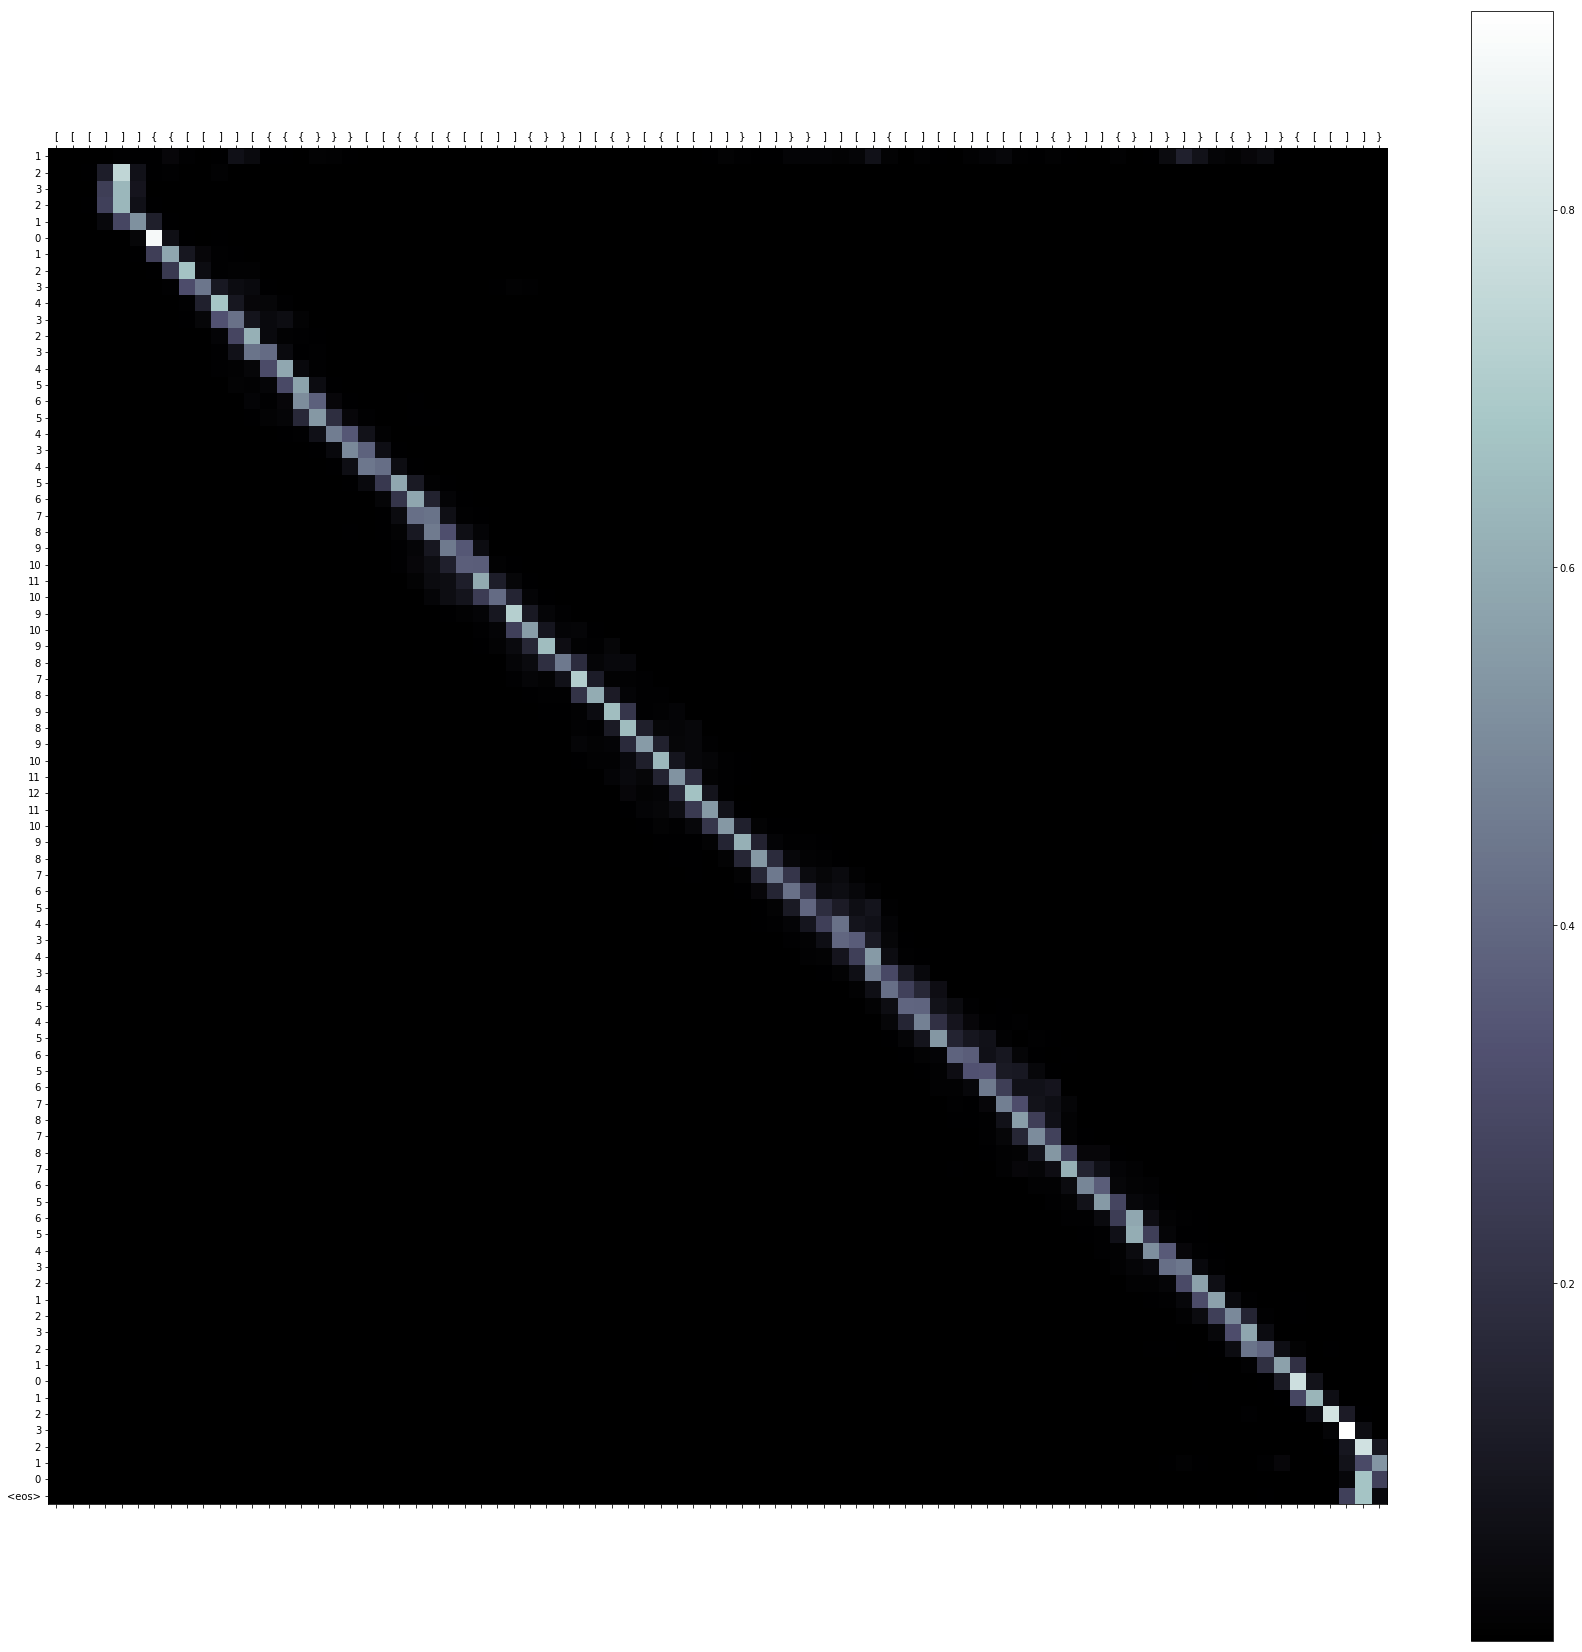

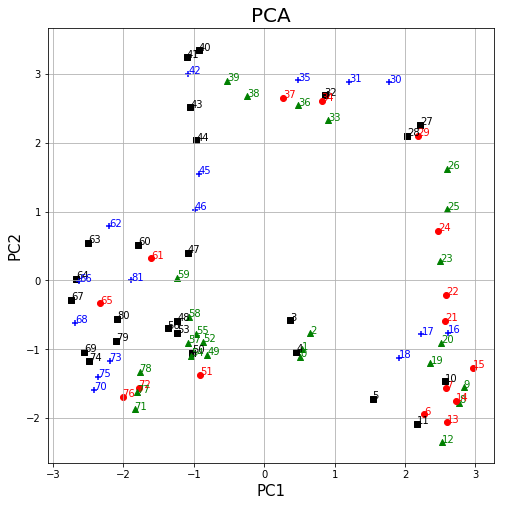

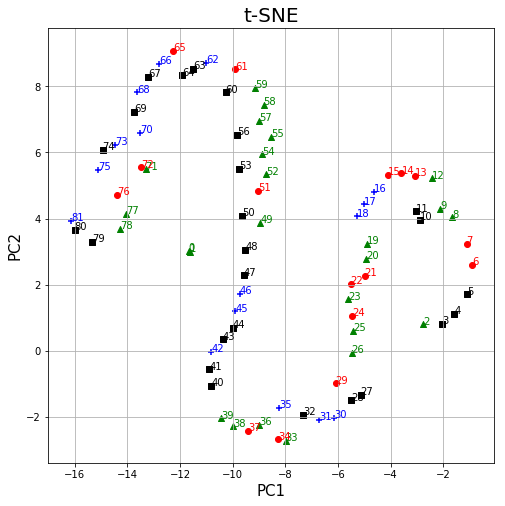

0 0 0 1 1 1 1 -1 -1 0 0 -1 -1 0 0 0 0 -1 -1 0 0 0 0 0 0 0 0 0 -1 -1 0 0 0 -1 0 0 0 0 0 0 0 -1 -1 0 0 0 0 0 0 0 0 0 0 0 -1 0 0 0 0 0 0 -1 0 0 0 0 0 0 0 -1 0 0 0 0 -1 -1 0 0 0 0 -1 -1 0
0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 -1 -1 -1 -1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 -1 -1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 -1 -1 -1 -1 -1 -1 -1 -1 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 -1 -1 0 0 -1 -1 -1 -1 0 0 0 -1 -1 0 0 0 0 -1 -1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 0 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 -1 -1 -1 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 0 0 0 0
0 0 0 0 1 1 0 -1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 0 -1 -1 1 1 0 -1 -1 -1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 0 0 0 0 0 0 -1 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

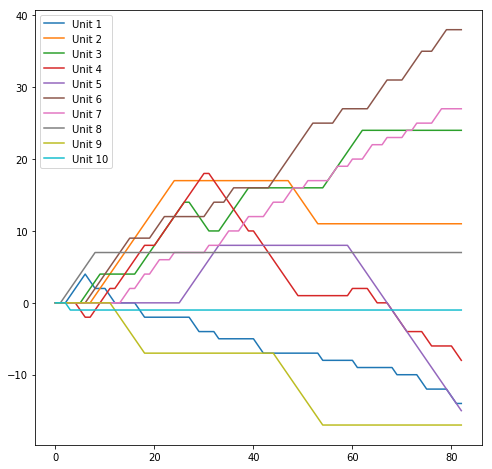

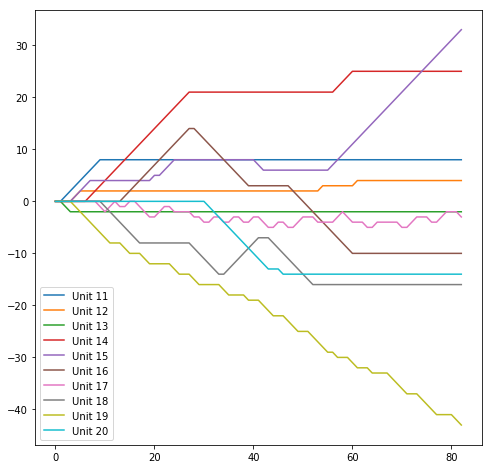

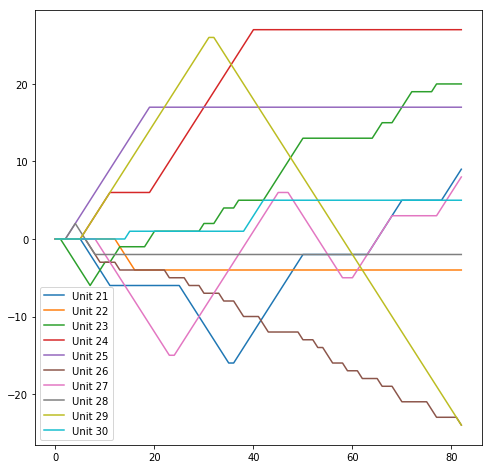

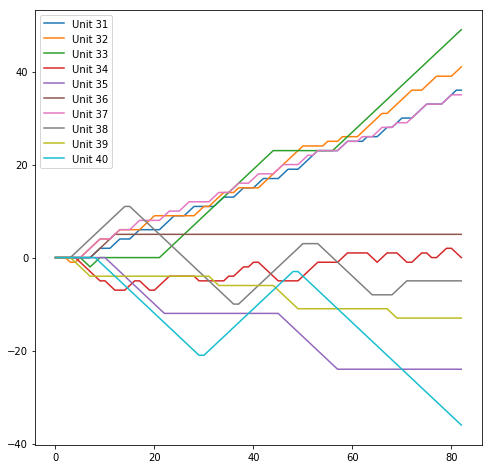

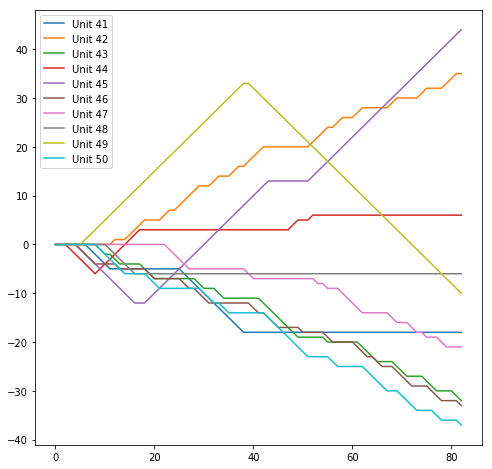

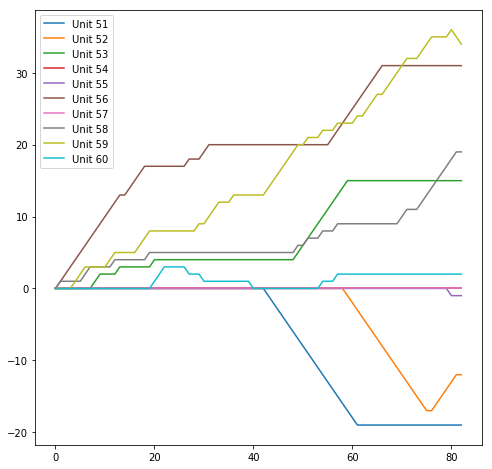

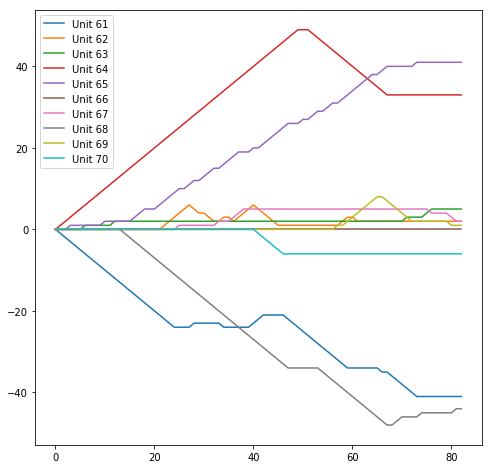

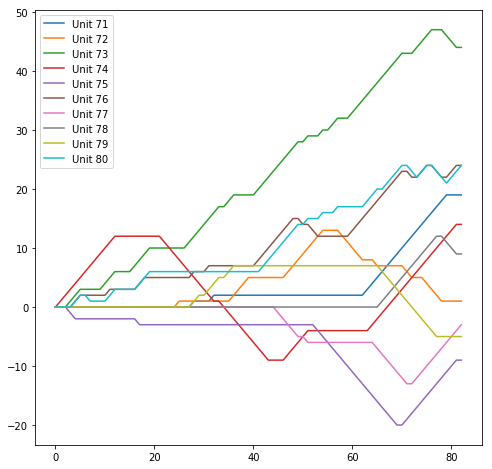

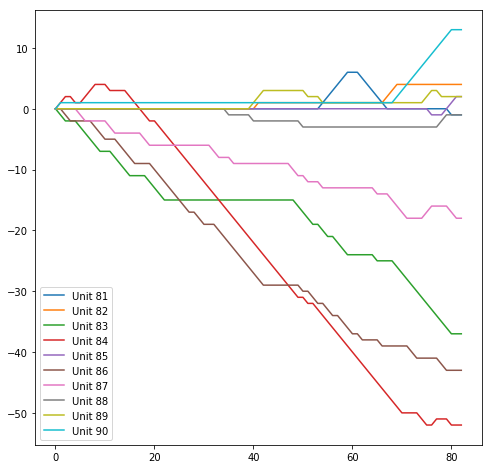

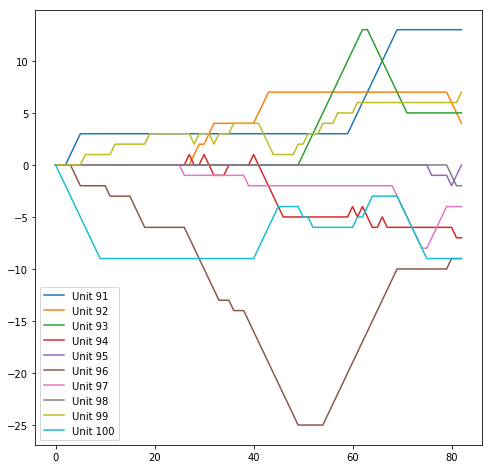

In [ ]:
try:
    while True:
        seq_str = input("input : ")
        seq = "".join(seq_str.strip().split())
        tgt_seq, tgt_att_list, encoder_outputs = predictor.predict(seq)
        tgt_seq_no, _, _ = predictor_no.predict(seq)
        print("Answer: " + answer_function(seq))
        print("Luong : " + " ".join(tgt_seq))
        print("None  : " + " ".join(tgt_seq_no))
        
        principalComponents = PCA(n_components=2)
        pca = principalComponents.fit_transform(encoder_outputs)
        
        print(encoder_outputs)
        
        hidden_to_av = []
        for i in range(len(encoder_outputs[0])):
            hidden_to_av.append([0])
        
        for i in range(len(encoder_outputs)):
            for j in range(len(encoder_outputs[i])):
                hidden_to_av[j].append(step_function(encoder_outputs[i][j]))
        
        fig = plt.figure(figsize=(30,30))
        ax = fig.add_subplot(111)
        cax = ax.matshow(tgt_att_list, cmap='bone')
        fig.colorbar(cax)
        
        ax.set_xticklabels([''] + list(seq))
        ax.set_yticklabels([''] + tgt_seq)
        
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        
        plt.show()
        
        fig2 = plt.figure(figsize=(8,8))
        ax2 = fig2.add_subplot(111)
        ax2.set_xlabel('PC1', fontsize = 15)
        ax2.set_ylabel('PC2', fontsize = 15)
        ax2.set_title('PCA', fontsize = 20)
        for i, j in zip(seq, range(len(pca))):
            if i == '{':
                ax2.scatter(pca[j][0], pca[j][1], c='r', label='{')
                ax2.annotate(str(j),(pca[j][0], pca[j][1]), color='r')
            elif i == '}':
                ax2.scatter(pca[j][0], pca[j][1], c='b', marker='+', label='}')
                ax2.annotate(str(j),(pca[j][0], pca[j][1]), color='b')
            elif i == '[':
                ax2.scatter(pca[j][0], pca[j][1], c='g', marker='^', label='[')
                ax2.annotate(str(j),(pca[j][0], pca[j][1]), color='g')
            elif i == ']':
                ax2.scatter(pca[j][0], pca[j][1], c='k', marker='s', label=']')
                ax2.annotate(str(j),(pca[j][0], pca[j][1]), color='k')
        #ax2.legend(bbox_to_anchor=(1, 1))
        ax2.grid()
        plt.show()
        
        tsne = TSNE(learning_rate=100)
        transformed = tsne.fit_transform(encoder_outputs)
        fig111 = plt.figure(figsize=(8,8))
        ax111 = fig111.add_subplot(111)
        
        ax111.set_xlabel('PC1', fontsize = 15)
        ax111.set_ylabel('PC2', fontsize = 15)
        ax111.set_title('t-SNE', fontsize = 20)
        for i, j in zip(seq, range(len(transformed))):
            if i == '{':
                ax111.scatter(transformed[j][0], transformed[j][1], c='r', label='{')
                ax111.annotate(str(j),(transformed[j][0], transformed[j][1]), color='r')
            elif i == '}':
                ax111.scatter(transformed[j][0], transformed[j][1], c='b', marker='+', label='}')
                ax111.annotate(str(j),(transformed[j][0], transformed[j][1]), color='b')
            elif i == '[':
                ax111.scatter(transformed[j][0], transformed[j][1], c='g', marker='^', label='[')
                ax111.annotate(str(j),(transformed[j][0], transformed[j][1]), color='g')
            elif i == ']':
                ax111.scatter(transformed[j][0], transformed[j][1], c='k', marker='s', label=']')
                ax111.annotate(str(j),(transformed[j][0], transformed[j][1]), color='k')
        #ax2.legend(bbox_to_anchor=(1, 1))
        ax111.grid()
        plt.show()
        
        fig_1 = plt.figure(figsize=(8,8))
        ax_1 = fig_1.add_subplot(111)
        fig_2 = plt.figure(figsize=(8,8))
        ax_2 = fig_2.add_subplot(111)
        fig_3 = plt.figure(figsize=(8,8))
        ax_3 = fig_3.add_subplot(111)
        fig_4 = plt.figure(figsize=(8,8))
        ax_4 = fig_4.add_subplot(111)
        fig_5 = plt.figure(figsize=(8,8))
        ax_5 = fig_5.add_subplot(111)
        fig_6 = plt.figure(figsize=(8,8))
        ax_6 = fig_6.add_subplot(111)
        fig_7 = plt.figure(figsize=(8,8))
        ax_7 = fig_7.add_subplot(111)
        fig_8 = plt.figure(figsize=(8,8))
        ax_8 = fig_8.add_subplot(111)
        fig_9 = plt.figure(figsize=(8,8))
        ax_9 = fig_9.add_subplot(111)
        fig_10 = plt.figure(figsize=(8,8))
        ax_10 = fig_10.add_subplot(111)
        
        for i in range(10):
            ax_1.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_1.legend()
            ax_1.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(10,20):
            ax_2.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_2.legend()
            ax_2.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(20,30):
            ax_3.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_3.legend()
            ax_3.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(30,40):
            ax_4.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_4.legend()
            ax_4.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(40,50):
            ax_5.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_5.legend()
            ax_5.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(50,60):
            ax_6.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_6.legend()
            ax_6.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(60,70):
            ax_7.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_7.legend()
            ax_7.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(70,80):
            ax_8.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_8.legend()
            ax_8.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(80,90):
            ax_9.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_9.legend()
            ax_9.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))
        for i in range(90,100):
            ax_10.plot(np.array(hidden_to_av[i]).cumsum(), label="Unit "+str(i+1))
            ax_10.legend()
            ax_10.grid()
            print(" ".join(map(str, list(hidden_to_av[i]))))

        plt.show()
        
except KeyboardInterrupt:
    pass